In [11]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from coherenceModel import *
from pipe import dedup, groupby, where, select, sort, chain, traverse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
reddit_df = pd.read_csv('reddit.csv').drop('Unnamed: 0', axis=1)
reddit_df

,content,subreddit
0,Well (and this is just speaking about our grou...,AskAcademia
1,I did this. I got my masters in mathematics th...,AskAcademia
2,I would say it's most definitely a possibility...,AskAcademia
3,"I sort of did this, but from undergrad to grad...",AskAcademia
4,"Sure, it's called going to grad school ;-) I'm...",AskAcademia
...,...,...
595,"The weapons are not hitscan, but the bullet tr...",gaming
596,a few friends of mine started playing rift. on...,gaming
597,"I like achievements and all, but it's rare tha...",gaming
598,speaking form an independent developer standpo...,gaming


In [14]:
reddit_df["num_sent"] = reddit_df.content.apply(lambda x : len(sent_tokenize(x)))

In [15]:
reddit_df["num_words"] = reddit_df.content.apply(lambda x : len(word_tokenize(x)))

In [30]:
subreddits = list(reddit_df["subreddit"].value_counts().keys())
subreddits

['AskAcademia', 'LawSchool', 'AskReddit', 'science', 'funny', 'gaming']

In [16]:
reddit_df

,content,subreddit,num_sent,num_words
0,Well (and this is just speaking about our grou...,AskAcademia,23,533
1,I did this. I got my masters in mathematics th...,AskAcademia,14,275
2,I would say it's most definitely a possibility...,AskAcademia,8,226
3,"I sort of did this, but from undergrad to grad...",AskAcademia,7,98
4,"Sure, it's called going to grad school ;-) I'm...",AskAcademia,5,150
...,...,...,...,...
595,"The weapons are not hitscan, but the bullet tr...",gaming,6,185
596,a few friends of mine started playing rift. on...,gaming,6,105
597,"I like achievements and all, but it's rare tha...",gaming,4,61
598,speaking form an independent developer standpo...,gaming,7,142


Mean of all: 224.16833333333332
SD of all: 206.7693723222943


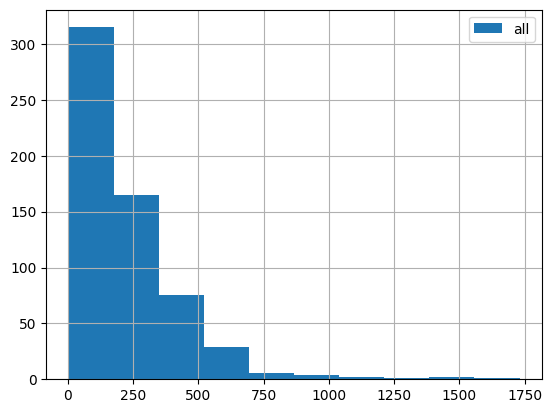

In [38]:
def get_statistics(series, title):
  print(f"Mean of {title}: {np.mean(series.values)}")
  print(f"SD of {title}: {np.sqrt(np.var(series.values))}")
  series.rename(title).hist(legend=True)
  
get_statistics(reddit_df.num_words, "all")

Mean of AskAcademia: 12.98
SD of AskAcademia: 9.95989959788752
Mean of LawSchool: 12.97
SD of LawSchool: 9.982439581585256
Mean of AskReddit: 12.21
SD of AskReddit: 10.085925837522304
Mean of science: 8.95
SD of science: 8.911088597921133
Mean of funny: 7.71
SD of funny: 7.783694495546443
Mean of gaming: 9.04
SD of gaming: 10.347869345908848


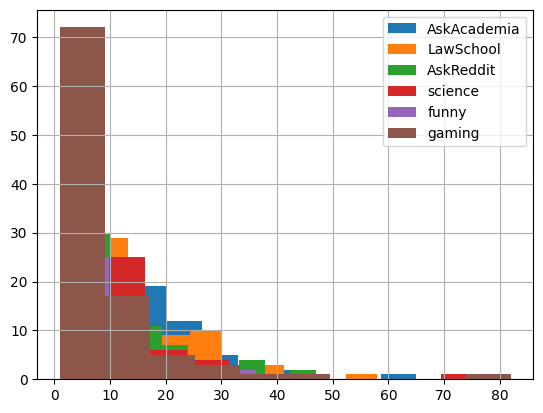

In [42]:
for subreddit in subreddits:
    get_statistics(reddit_df[reddit_df["subreddit"] == subreddit].num_sent, subreddit)

In [46]:
filtered_subreddits = reddit_df[reddit_df["num_sent"] >= 5]
filtered_subreddits["subreddit"].value_counts()

subreddit
AskAcademia    88
LawSchool      82
AskReddit      81
science        77
gaming         68
funny          55
Name: count, dtype: int64

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [59]:
basic_model = FFNN(5, device)
basic_model.load_state_dict(torch.load('best_rnn.pt'))
basic_model.eval()
basic_model.to(device)
wsize = 5

In [48]:
import gensim.downloader
embed = gensim.downloader.load("glove-wiki-gigaword-50")
unk = np.mean(embed.vectors, axis=0)

In [62]:
def get_windows(post, window_size):
    sentences = get_paragraph_embedding_tup(embed, unk, post)
    num_windows = len(sentences) - window_size + 1
                
    if num_windows < 0:
        print(f"WARNING: Post did not have enough sentences for window size {window_size}; returning None")
        return None
    
    return [tensor_of_tupled_par_embed(sentences[i:i+window_size]) for i in range(num_windows)]

In [73]:
def get_coherence(post):
    windows_of_post = get_windows(post, wsize)
    with torch.no_grad():
        windows = [[s.to(device) for s in window] for window in windows_of_post]
        scores = torch.sigmoid(basic_model(windows))
        return torch.mean(scores).tolist()

/tmp/ipykernel_18873/2578076136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subreddits['coherence'] = filtered_subreddits.content.apply(get_coherence)


<Axes: >

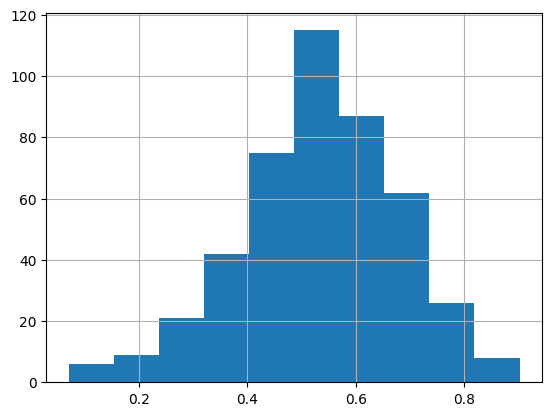

In [74]:
filtered_subreddits['coherence'] = filtered_subreddits.content.apply(get_coherence)
filtered_subreddits.coherence.hist()

Mean of AskAcademia: 0.5568155585364862
SD of AskAcademia: 0.1255734131829495
Mean of LawSchool: 0.5201205318657364
SD of LawSchool: 0.11599824941637735
Mean of AskReddit: 0.5238010141952538
SD of AskReddit: 0.15214121443036013
Mean of science: 0.5463853699046296
SD of science: 0.17785123923051263
Mean of funny: 0.5262214897708459
SD of funny: 0.1533847597014325
Mean of gaming: 0.5236281682463253
SD of gaming: 0.1491866360461201


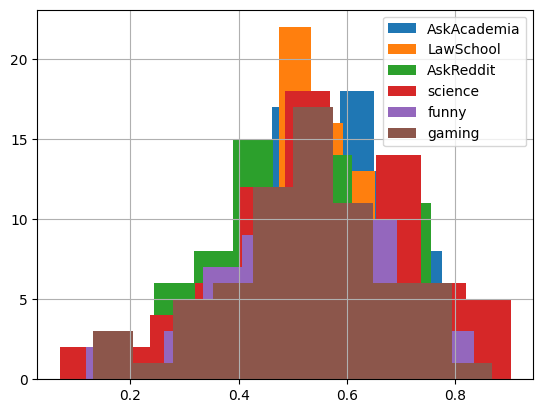

In [75]:
for subreddit in subreddits:
    get_statistics(filtered_subreddits[filtered_subreddits["subreddit"] == subreddit].coherence, subreddit)

In [76]:
aviation_df = pd.read_csv('moreAviationPerms.csv')
only_coherent_aviation = aviation_df[aviation_df['is_coherent'] == 1]
only_coherent_aviation

,paragraph,is_coherent
0,The preflight inspection of the fuel tanks by ...,1
1,"The pilot reported that he was cleared to 4,00...",1
2,The instrument-rated private pilot lost contro...,1
3,The non-instrument rated private pilot was rec...,1
4,The commercial pilot reported a partial power ...,1
...,...,...
1995,Personnel at the airport reported that the bat...,1
1996,The student pilot reported that he was practic...,1
1997,The commercial certificated pilot was maneuver...,1
1998,The private pilot of the amateur built experim...,1


/tmp/ipykernel_18873/217935567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_coherent_aviation['coherence'] = only_coherent_aviation.paragraph.apply(get_coherence)


<Axes: >

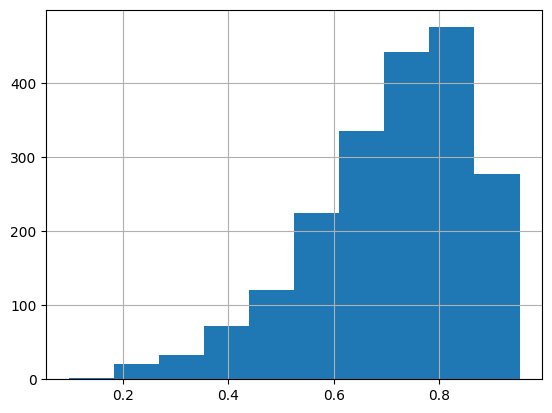

In [78]:
only_coherent_aviation['coherence'] = only_coherent_aviation.paragraph.apply(get_coherence)
only_coherent_aviation.coherence.hist()

In [79]:
only_coherent_aviation.to_csv('aviationWithCoherence.csv')
filtered_subreddits.to_csv('subredditsWithCoherence.csv')